<a href="https://colab.research.google.com/github/lasseke/ee-cnn-nin-classification/blob/main/vegetation_one_hot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import libraries

In [ ]:
!pip install tensorflow~=2.13.0

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [ ]:
#Script adapted from: https://colab.research.google.com/github/google/earthengine-community/blob/master/guides/linked/Earth_Engine_Vertex_AI_training_demo.ipynb#scrollTo=P2OsyrJ7HAhE

EE_PROJECT = 'ee-adamnaas'

import ee
import google.cloud
import random
from google.colab import auth
#from google.cloud import storage

import tensorflow as tf
print(tf.__version__)

from tensorflow import keras
from keras import layers, models

from pprint import pprint

# Authentication
auth.authenticate_user()
ee.Authenticate()

ee.Initialize(project = EE_PROJECT)

2.13.0


#Set parameters

In [ ]:
BUCKET = 'us-buck'

BANDS = ['B11','B12','B2','B3','B4','B5','B6','B7','B8','B8A','PR','VH','VV','asp','dem','evi','ndmi','ndsm','ndvi','slp','tri']

CLASSES = ['1a','1b','1c','2a','2b','2c','2d','2e','2f','2g','3a','3b','4a','4b','4c','4d','4e','4f','4g','5b','6a','6b','6c','6d','7a','7b','7c','8a',
         '8b','8c','8d','9a','9b','9c','9d','9e','10a','10b','10c','10d','10e','10f','10g','11a','11b','12a','12b','12c','12d','12e','12f','12g','13a','13b']

# Function to generate random colors in hexadecimal format
def generate_random_color():
    return ''.join([random.choice('0123456789ABCDEF') for _ in range(6)])

# Generate a random color for each class
CLASSIFICATIONS = {class_name: generate_random_color() for class_name in CLASSES}

N_CLASSES = len(CLASSES)

LABEL = 'B0'
N_CLASSES = 54

N_EXAMPLES = 10
BATCH_SIZE = 1
TRAIN_EXAMPLES = int(0.8 * N_EXAMPLES)
VAL_EXAMPLES = N_EXAMPLES - TRAIN_EXAMPLES

N_EPOCHS = 1
STEPS_PER_EPOCH = int(TRAIN_EXAMPLES / BATCH_SIZE)

N_BANDS = len(BANDS)
PATCH_SIZE = 128

FEATURE_NAMES = BANDS + [LABEL]
N_FEATURES = len(FEATURE_NAMES)

COLUMNS = [
  tf.io.FixedLenFeature(shape=[128,128], dtype=tf.float32) for k in FEATURE_NAMES
]

# Dictionary with feature names as keys, fixed-length features as values.
FEATURES_DICT = dict(zip(FEATURE_NAMES, COLUMNS))

FILE_PATH = 'gs://' + BUCKET + '/vegetation_data/'

OUTPUT_DIR = 'us-buck'
MODEL_DIR = 'us-buck'

# Name of the hosted model and endpoint.
MODEL_NAME = 'cnn_model'
ENDPOINT_NAME = 'cnn_endpoint'

# A container image that can run the hosted model.
CONTAINER_IMAGE = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-13:latest'  #'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-11:latest'

PROJECT = 'spatial-victory-416321'
REGION = 'us-central1'

ATTRIBUTION = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>'


print('Found training file.' if tf.io.gfile.exists(FILE_PATH)
    else 'No training file found.')

Found training file.


#Import and parse data

In [ ]:
def load_dataset(tfrecord_files):
    return tf.data.TFRecordDataset(tfrecord_files, compression_type='GZIP')

def parse_tfrecord(example_proto):
  """Deserialize an example proto.  Return (inputs, labels)"""
  parsed_features = tf.io.parse_example(example_proto, FEATURES_DICT)
  labels = parsed_features.pop(LABEL)
  return ({k: tf.expand_dims(v, axis=2) for k, v in parsed_features.items()},
          tf.one_hot(tf.cast(labels, tf.uint8), len(CLASSIFICATIONS)))

file_paths = [f"{FILE_PATH}{i}.tfrecord.gz" for i in range(1, N_EXAMPLES+1)]
dataset = load_dataset(file_paths)

# Map the function over the dataset.
parsed_dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)

train_dataset = parsed_dataset.take(TRAIN_EXAMPLES)
val_dataset = parsed_dataset.skip(TRAIN_EXAMPLES)

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# Print the first parsed record to check.
#pprint(iter(train_dataset).next())

In [ ]:
parsed_dataset

<_ParallelMapDataset element_spec=({'B11': TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None), 'B12': TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None), 'B2': TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None), 'B3': TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None), 'B4': TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None), 'B5': TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None), 'B6': TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None), 'B7': TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None), 'B8': TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None), 'B8A': TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None), 'PR': TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None), 'VH': TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None), 'VV': TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None), 'asp': TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None), 'dem': T

#Define model

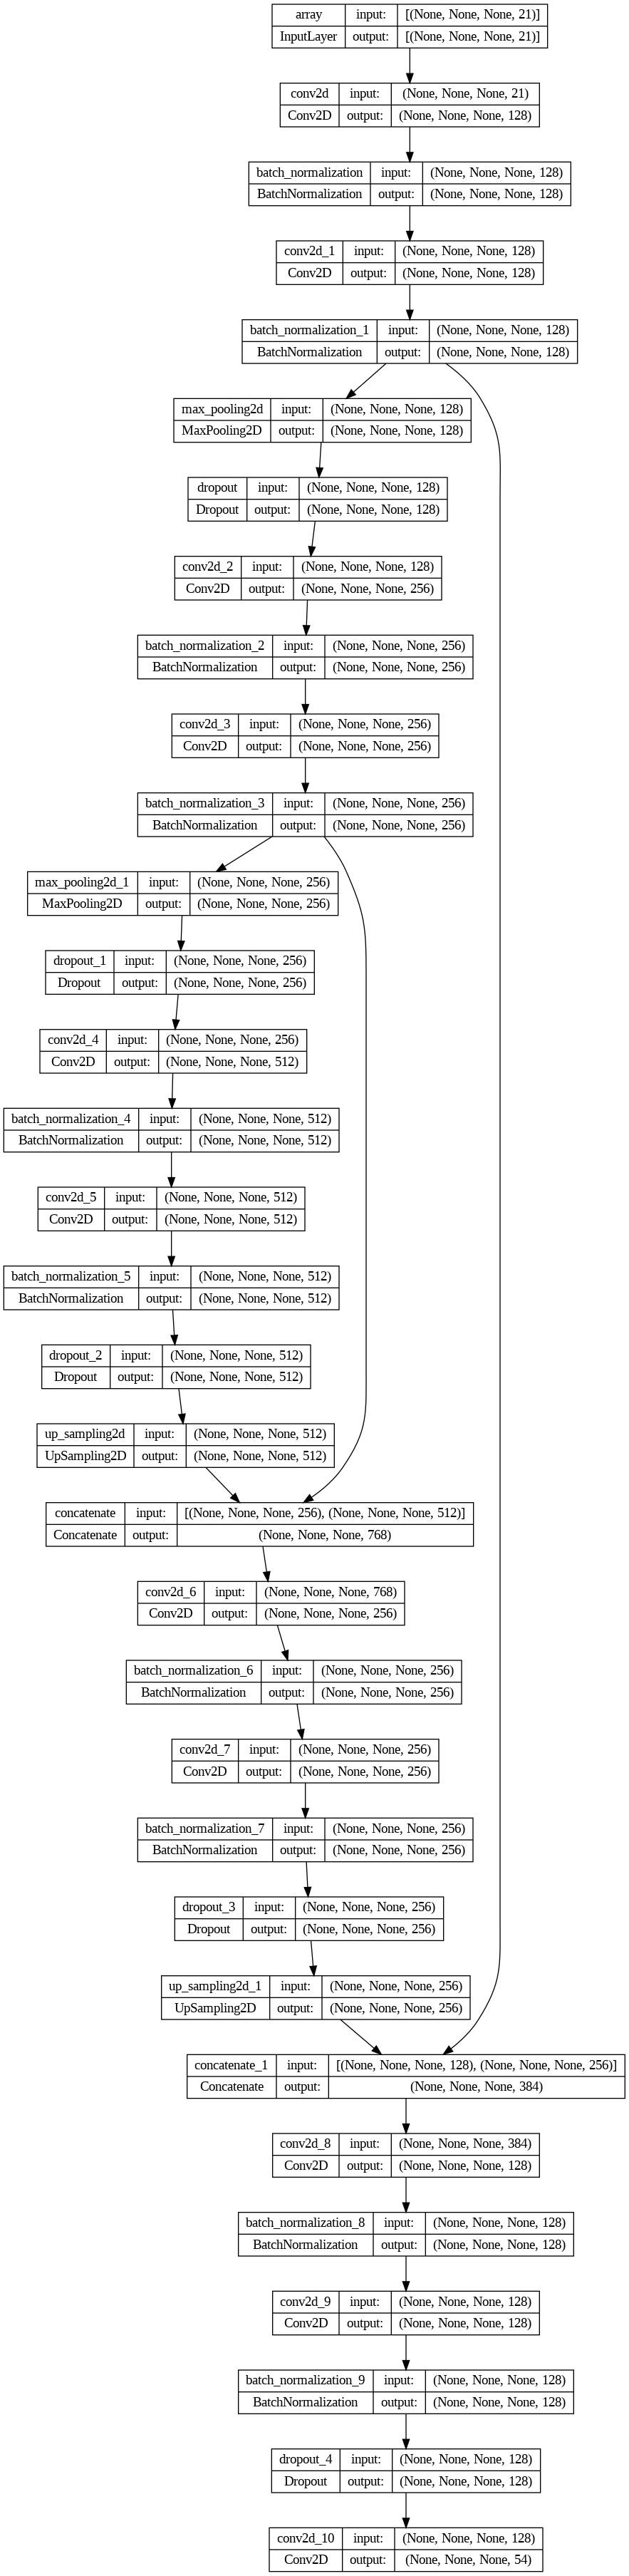

In [ ]:
inputs = keras.Input(shape=[None, None, N_BANDS], name='array')
conv1 = layers.Conv2D(128, (3,3), activation=tf.nn.relu, padding='same')(inputs)
conv1 = layers.BatchNormalization()(conv1)
conv1 = layers.Conv2D(128, (3,3), activation=tf.nn.relu, padding='same')(conv1)
conv1 = layers.BatchNormalization()(conv1)
pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
pool1 = layers.Dropout(0.2)(pool1)

conv2 = layers.Conv2D(256, (3,3), activation=tf.nn.relu, padding='same')(pool1)
conv2 = layers.BatchNormalization()(conv2)
conv2 = layers.Conv2D(256, (3,3), activation=tf.nn.relu, padding='same')(conv2)
conv2 = layers.BatchNormalization()(conv2)
pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
pool2 = layers.Dropout(0.2)(pool2)

conv3 = layers.Conv2D(512, (3,3), activation=tf.nn.relu, padding='same')(pool2)
conv3 = layers.BatchNormalization()(conv3)
conv3 = layers.Conv2D(512, (3,3), activation=tf.nn.relu, padding='same')(conv3)
conv3 = layers.BatchNormalization()(conv3)
conv3 = layers.Dropout(0.2)(conv3)

up1 = layers.UpSampling2D(size=(2, 2))(conv3)
concat1 = layers.concatenate([conv2, up1], axis=-1)
conv4 = layers.Conv2D(256, (3,3), activation=tf.nn.relu, padding='same')(concat1)
conv4 = layers.BatchNormalization()(conv4)
conv4 = layers.Conv2D(256, (3,3), activation=tf.nn.relu, padding='same')(conv4)
conv4 = layers.BatchNormalization()(conv4)
conv4 = layers.Dropout(0.2)(conv4)

up2 = layers.UpSampling2D(size=(2, 2))(conv4)
concat2 = layers.concatenate([conv1, up2], axis=-1)
conv5 = layers.Conv2D(128, (3,3), activation=tf.nn.relu, padding='same')(concat2)
conv5 = layers.BatchNormalization()(conv5)
conv5 = layers.Conv2D(128, (3,3), activation=tf.nn.relu, padding='same')(conv5)
conv5 = layers.BatchNormalization()(conv5)
conv5 = layers.Dropout(0.2)(conv5)

outputs = layers.Conv2D(N_CLASSES, (1, 1), activation=tf.nn.softmax)(conv5)
#outputs = layers.Argmax(axis=-1)(outputs)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

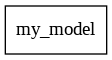

In [ ]:
tf.keras.utils.plot_model(wrapped_model, show_shapes=True, show_layer_names=True)

In [ ]:
# A Layer to stack and reshape the input tensors.
class MyPreprocessing(keras.layers.Layer):
  def __init__(self, **kwargs):
    super(MyPreprocessing, self).__init__(**kwargs)

  def call(self, features_dict):
    # (None, 1, 1, 1) -> (None, 1, 1, P)
    return tf.concat([features_dict[b] for b in BANDS], axis=3)

  def get_config(self):
    config = super().get_config()
    return config


# A Model that wraps the base model with the preprocessing layer.
class MyModel(keras.Model):
  def __init__(self, preprocessing, backbone, **kwargs):
    super().__init__(**kwargs)
    self.preprocessing = preprocessing
    self.backbone = backbone

  def call(self, features_dict):
    x = self.preprocessing(features_dict)
    return self.backbone(x)

  def get_config(self):
    config = super().get_config()
    return config

wrapped_model = MyModel(MyPreprocessing(), model)

In [ ]:
wrapped_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
              tf.keras.metrics.OneHotIoU(
                        num_classes=len(CLASSIFICATIONS),
                        target_class_ids=list(range(len(CLASSIFICATIONS))),
                        ),
          tf.keras.metrics.Accuracy(),
          ]
    )

history = wrapped_model.fit(
          train_dataset,
          validation_data=val_dataset,
          epochs=N_EPOCHS,
          callbacks=[tf.keras.callbacks.TensorBoard(
              'us-buck/logs', histogram_freq=1)],
          )

8/8 [==============================] - 54s 6s/step - loss: 4.0304 - one_hot_io_u_1: 0.0065 - accuracy: 0.0000e+00 - val_loss: 8149.0347 - val_one_hot_io_u_1: 0.0000e+00 - val_accuracy: 0.9451


In [ ]:
history.history

{'loss': [4.030446529388428],
 'one_hot_io_u_1': [0.006499537266790867],
 'accuracy': [0.0],
 'val_loss': [8149.03466796875],
 'val_one_hot_io_u_1': [0.0],
 'val_accuracy': [0.9450802206993103]}

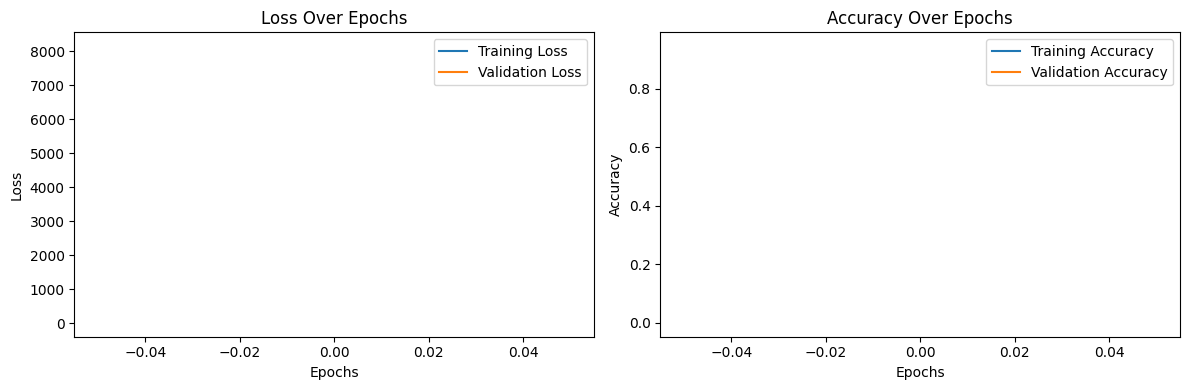

In [ ]:
import matplotlib.pyplot as plt

# Plot the training history
plt.figure(figsize=(12, 4))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()

In [ ]:
wrapped_model.save(OUTPUT_DIR)

In [ ]:
trained_model = keras.models.load_model(OUTPUT_DIR)
print(trained_model.inputs)

None


In [ ]:
trained_model

In [ ]:
predictions = trained_model.predict(train_dataset)

9/9 [==============================] - 11s 1s/step


In [ ]:
predictions.shape

(8, 128, 128, 54)

In [ ]:
class DeSerializeInput(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def call(self, inputs_dict):
    return {
      k: tf.map_fn(lambda x: tf.io.parse_tensor(x, tf.float32),
                   tf.io.decode_base64(v),
                   fn_output_signature=tf.float32)
        for (k, v) in inputs_dict.items()
    }

  def get_config(self):
    config = super().get_config()
    return config


class ReSerializeOutput(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def call(self, output_tensor):
    return tf.map_fn(lambda x: tf.io.encode_base64(tf.io.serialize_tensor(x)),
                    output_tensor,
                    fn_output_signature=tf.string)

  def get_config(self):
    config = super().get_config()
    return config

input_deserializer = DeSerializeInput()
output_deserializer = ReSerializeOutput()

serialized_inputs = {
    b: tf.keras.Input(shape=[], dtype='string', name=b) for b in BANDS
}

updated_model_input = input_deserializer(serialized_inputs)
updated_model = trained_model(updated_model_input)
updated_model = output_deserializer(updated_model)
updated_model = tf.keras.Model(serialized_inputs, updated_model)

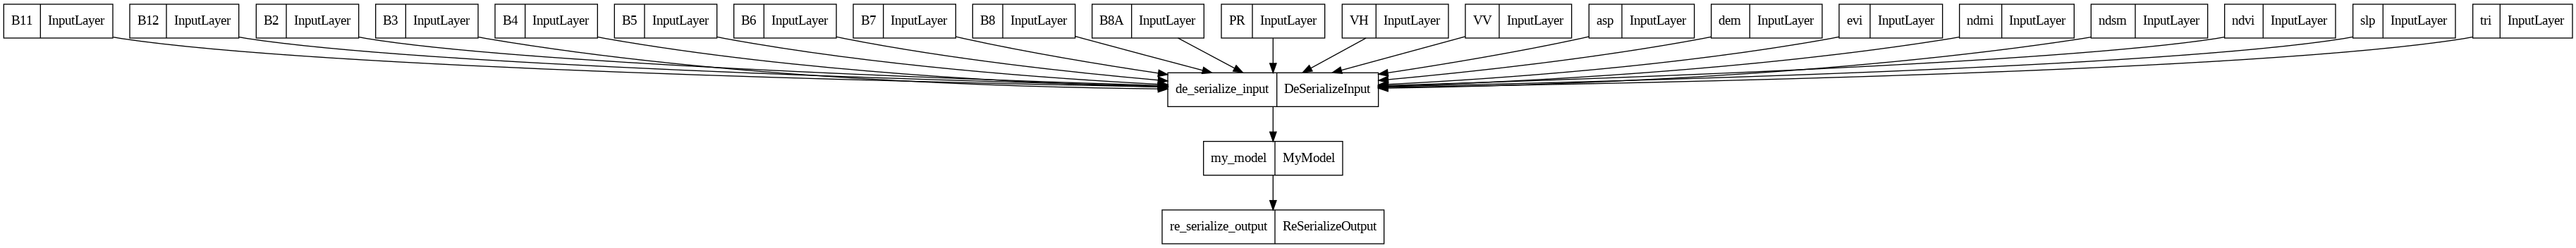

In [ ]:
tf.keras.utils.plot_model(updated_model)

In [ ]:
# Assume `model` is your trained Keras model
updated_model.save("saved_model", save_format="tf")

In [ ]:
!gsutil cp -r saved_model gs://{MODEL_DIR}

Copying file://saved_model/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://saved_model/keras_metadata.pb [Content-Type=application/octet-stream]...
Copying file://saved_model/fingerprint.pb [Content-Type=application/octet-stream]...
Copying file://saved_model/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
\ [4 files][ 30.4 MiB/ 30.4 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://saved_model/variables/variables.index [Content-Type=application/octet-stream]...
\ [5 files][ 30.4 MiB/ 30.4 MiB]                                                
Operation completed over 5 objects/30.4 MiB.                                     


In [ ]:
!gcloud ai models delete {MODEL_NAME} --project={PROJECT} --region={REGION}

Using endpoint [https://us-central1-aiplatform.googleapis.com/]


In [ ]:
!echo {'gs://' + MODEL_DIR + '/saved_model/'}

gs://us-buck/saved_model/


In [ ]:
!gcloud ai models upload \
  --artifact-uri={'gs://' + MODEL_DIR + '/saved_model/'} \
  --project={PROJECT} \
  --region={REGION} \
  --container-image-uri={CONTAINER_IMAGE} \
  --description={MODEL_NAME} \
  --display-name={MODEL_NAME} \
  --model-id={MODEL_NAME}

Using endpoint [https://us-central1-aiplatform.googleapis.com/]


In [ ]:
!gcloud ai endpoints create \
  --display-name={ENDPOINT_NAME} \
  --region={REGION} \
  --project={PROJECT}

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Created Vertex AI endpoint: projects/917460535764/locations/us-central1/endpoints/8542986545005592576.


In [ ]:
ENDPOINT_ID = 8542986545005592576

In [ ]:
!gcloud ai endpoints deploy-model {ENDPOINT_ID} \
  --project={PROJECT} \
  --region={REGION} \
  --model={MODEL_NAME} \
  --display-name={MODEL_NAME}

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Deployed a model to the endpoint 8542986545005592576. Id of the deployed model: 7447235246996586496.


In [ ]:
DEPLOYED_MODEL_ID = 7447235246996586496

In [ ]:
# Define the base path to the GeoTIFF images in Google Cloud Storage
base_path_dem = 'gs://scale-paper/cog/'
base_path_dsm = 'gs://scale-paper/cog_dsm/'

In [ ]:
import geemap

# Load a feature or feature collection (for example, countries from Large Scale International Boundary polygons).
countries = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')

# Select a specific country by its name, e.g., Norway.
norway = countries.filter(ee.Filter.eq('country_na', 'Norway'))

# Get the geometry of the selected feature or features.
norway_geometry = norway.geometry()

# Set CRS
CRS = 'EPSG:25833'
SCALE = 10

# Create a map centered on Norway
Map = geemap.Map(center=[61, 8], zoom=5)

# Reproject the region to the desired CRS.
region = norway_geometry.transform(ee.Projection(CRS).atScale(SCALE), 1)

# Add the reprojected layer to the map.
#Map.addLayer(region, {'color': 'red'}, 'Norway (EPSG:25833)')

# Display the map.
#Map

In [ ]:
# Generate an empty image collection
merged_collection_dem = ee.ImageCollection([])
merged_collection_dsm = ee.ImageCollection([])

# Loop through each image and import the GeoTIFF images for DEM
for i in range(1, 255):
    # Generate the file path for the current image
    image_path = f"{base_path_dem}{i}.tif"

    # Import the GeoTIFF image
    image = ee.Image.loadGeoTIFF(image_path).rename('dem').reproject(crs=CRS, scale=SCALE)

    # Add the image to the merged image collection
    merged_collection_dem = merged_collection_dem.merge(image)

dem = merged_collection_dem.mosaic().setDefaultProjection(crs=CRS, scale=SCALE)

# Loop through each image and import the GeoTIFF images for DSM
for i in range(1, 255):
    # Generate the file path for the current image
    image_path = f"{base_path_dsm}{i}.tif"

    # Import the GeoTIFF image
    image = ee.Image.loadGeoTIFF(image_path).rename('dsm').reproject(crs=CRS, scale=SCALE)

    # Add the image to the merged image collection
    merged_collection_dsm = merged_collection_dsm.merge(image)

dsm = merged_collection_dsm.mosaic().setDefaultProjection(crs=CRS, scale=SCALE)

# Create the nDSM by subtracting the DEM from the DSM
ndsm = dsm.subtract(dem).rename('ndsm').setDefaultProjection(crs=CRS, scale=SCALE)

In [ ]:
# Define a function to compute the terrain ruggedness index
def compute_tri(image):
    kernel = ee.Kernel.square(radius=1)

    # Compute the elevation difference between each pixel and its neighbors
    neighbors = image.reduceNeighborhood(reducer=ee.Reducer.stdDev(), kernel=kernel)

    return neighbors.rename('tri').setDefaultProjection(crs=CRS, scale=SCALE)

# Compute the slope
slope = ee.Terrain.slope(dem).setDefaultProjection(crs=CRS, scale=SCALE)

# Compute the slope
aspect = ee.Terrain.aspect(dem).setDefaultProjection(crs=CRS, scale=SCALE)

# Compute the TRI
tri = compute_tri(dem).setDefaultProjection(crs=CRS, scale=SCALE)

In [ ]:
# Function to calculate PR
def calculate_pr(image):
    pr = image.expression(
        'VV / VH', {
            'VV': image.select('VV'),
            'VH': image.select('VH')
        }).rename('PR')
    return image.addBands(pr).setDefaultProjection(crs=CRS, scale=SCALE)

# Define date filters
start_date = '2014-10-03'
end_date = '2024-09-11'

# Month range to subset
start_month = 6
end_month = 8

# Prepare Sentinel-2 data
sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
            .filterDate(start_date, end_date) \
            .filter(ee.Filter.calendarRange(start_month, end_month, 'month')) \
            .filter(ee.Filter.eq('instrumentMode', 'IW')) \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
            .map(calculate_pr) \
            .map(lambda image: image.reproject(crs=CRS, scale=SCALE)) \
            .filterBounds(region) \
            .median()

# Set default projection for the final median image
sentinel1 = sentinel1.setDefaultProjection(crs=CRS, scale=SCALE)

# Define the relevant bands from the Sentinel-2 image to avoid inconsistency
sentinel1_selected = sentinel1.select(['PR', 'VV', 'VH'])

In [ ]:
# Function to ensure the required band order and data type consistency
def standardize_bands(image, order):
    # Select and re-order bands according to the required order
    standardized = image.select(order)
    return standardized

# Function to calculate NDVI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename("ndvi")
    return image.addBands(ndvi).setDefaultProjection(crs=CRS, scale=SCALE)

# Function to calculate EVI
def calculate_evi(image):
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
            'NIR': image.select('B8'),
            'RED': image.select('B4'),
            'BLUE': image.select('B2')
        }).rename('evi')
    return image.addBands(evi).setDefaultProjection(crs=CRS, scale=SCALE)

# Function to calculate NDMI
def calculate_ndmi(image):
    ndmi = image.expression(
        '(NIR - SWIR1) / (NIR + SWIR1)', {
            'NIR': image.select('B8'),
            'SWIR1': image.select('B11')
        }).rename('ndmi')
    return image.addBands(ndmi).setDefaultProjection(crs=CRS, scale=SCALE)

# Define date filters
start_date = "2017-06-01"
end_date = "2021-09-01"

# Month range to subset
start_month = 6
end_month = 8

# Function to mask clouds based on the QA60 band
def mask_clouds(image):
    qa = image.select('QA60')
    cloud_mask = qa.bitwiseAnd(1 << 10).eq(0) \
    .And(qa.bitwiseAnd(1 << 11).eq(0))
    return image.updateMask(cloud_mask).setDefaultProjection(crs=CRS, scale=SCALE)

# Prepare Sentinel-2 data
sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
            .select('B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12','QA60') \
            .filterDate(start_date, end_date) \
            .filter(ee.Filter.calendarRange(start_month, end_month, 'month')) \
            .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 50) \
            .map(calculate_ndvi) \
            .map(calculate_evi) \
            .map(calculate_ndmi) \
            .map(mask_clouds) \
            .map(lambda image: image.reproject(crs=CRS, scale=SCALE)) \
            .filterBounds(region) \
            .median()

# Set default projection for the final median image
sentinel2 = sentinel2.setDefaultProjection(crs=CRS, scale=SCALE)

# Define the relevant bands from the Sentinel-2 image to avoid inconsistency
sentinel2_selected = sentinel2.select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'ndvi', 'evi', 'ndmi'])

In [ ]:
# Assemble features
image = dem.rename('dem').toFloat() \
    .addBands(slope.rename('slp')).toFloat() \
    .addBands(aspect.rename('asp')).toFloat() \
    .addBands(tri.rename('tri')).toFloat() \
    .addBands(ndsm.rename('ndsm')).toFloat() \
    .addBands(sentinel1_selected).toFloat() \
    .addBands(sentinel2_selected).toFloat()

In [ ]:
endpoint_path = (
    'projects/' + PROJECT + '/locations/' + REGION + '/endpoints/' + str(ENDPOINT_ID)
)
print(endpoint_path)

projects/spatial-victory-416321/locations/us-central1/endpoints/8542986545005592576


In [ ]:
# Connect to the hosted model.
vertex_model = ee.Model.fromVertexAi(**{
  'endpoint': endpoint_path,
  'inputTileSize': [64, 64],
  'inputOverlapSize': [32, 32],
  'proj': ee.Projection(CRS).atScale(SCALE),
  'fixInputProj': True,
  'outputBands': {'output': {
      'type': ee.PixelType.float(),
      'dimensions': 1
    }
  }
})

predictions = vertex_model.predictImage(image.select(BANDS).float())
labels = predictions.arrayArgmax().arrayGet(0).rename('label')

vis_params = {
  'min': 0,
  'max': len(CLASSIFICATIONS) - 1,
  'palette': list(CLASSIFICATIONS.values()),
  'bands': ['label'],
}

In [ ]:
predictions.getInfo()

{'type': 'Image',
 'bands': [{'id': 'output',
   'data_type': {'type': 'PixelType', 'precision': 'float', 'dimensions': 1},
   'crs': 'EPSG:25833',
   'crs_transform': [10, 0, 0, 0, 10, 0]}]}

In [ ]:
task = ee.batch.Export.image.toAsset(
    image=predictions,
    description='predictions-test',
    assetId='projects/spatial-victory-416321/assets/preds_test',  # <> modify these
)

In [ ]:
task.start()

In [ ]:
import folium

# Get a URL to serve image tiles.
mapid = image.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000})

# Use folium to visualize the imagery.
map = folium.Map(location=[60.75,10.52])

# Inputs.
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr=ATTRIBUTION,
    overlay=True,
    name='median composite',
  ).add_to(map)

tile_url = labels.getMapId(vis_params)
folium.TileLayer(
    tiles=tile_url['tile_fetcher'].url_format,
    attr=ATTRIBUTION,
    overlay=True,
    name='labels',
  ).add_to(map)

map.add_child(folium.LayerControl())
display(map)